In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns

import skimage
import skimage.io
from skimage.exposure import histogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples

import sys
sys.path.insert(0,'../')
from helper import classification_tools as ct
from helper import visualize as vis

%matplotlib inline

# Sensitivity Analysis- No Histogram Equalization
## Loading data
Same process as standard analysis but with different file for the new features.

In [2]:
feature_path = Path('..','data','features','VGG16_fc1_features_NoHistEQ.pickle')
assert feature_path.is_file()

le_path = Path('..','models','label_encoder.pickle')
assert le_path.is_file()


with open(feature_path, 'rb') as f:
    data = pickle.load(f)

with open(le_path, 'rb') as f:
    le = pickle.load(f)


In [3]:
files = data['filename']
fc1 = data['features']
labels = data['labels']
y_gt = le.transform(labels)
labels_ordered = le.inverse_transform(range(len(le.classes_)))

# Dimension reduction
## PCA

variance preserved by 50 components: 0.770


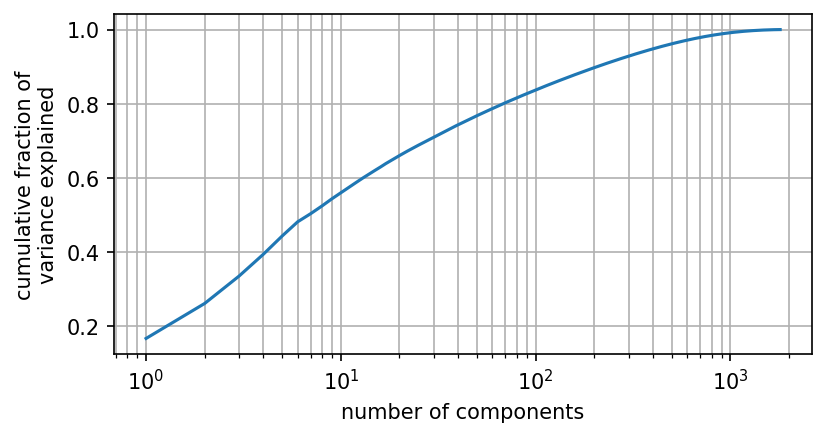

In [4]:
pca_n = PCA(svd_solver='full')
x_pca_ = pca_n.fit_transform(fc1)

var_ = pca_n.explained_variance_ratio_.cumsum()


fig, ax = plt.subplots(figsize=(6,3),dpi=150,)
ax.grid('on', which='both')
ax.plot(range(1,len(var_)+1), var_)
ax.set_xscale('log')
ax.set_xlabel('number of components')
ax.set_ylabel('cumulative fraction of\nvariance explained')
print('variance preserved by 50 components: {:.3f}'.format(var_[50]))

Before, 50 components only preserved 74% of the variance. Removing histogram equalization actually increases the amount of variance explained by the first 50 components, as the relative brightness of features is preserved in the features.

## T-SNE Visualization

In [5]:
pca = PCA(n_components=50, svd_solver='full', whiten=True)
pca_nw = PCA(n_components=50, svd_solver='full', whiten=False)
x = pca.fit_transform(fc1)
x_nw = pca_nw.fit_transform(fc1)

In [6]:
tsne = TSNE(n_components=2, random_state=605196619)
tsne_w = TSNE(n_components=2, random_state=3618296892)
x_nw_tsne = tsne.fit_transform(x_nw)
x_w_tsne = tsne_w.fit_transform(x)

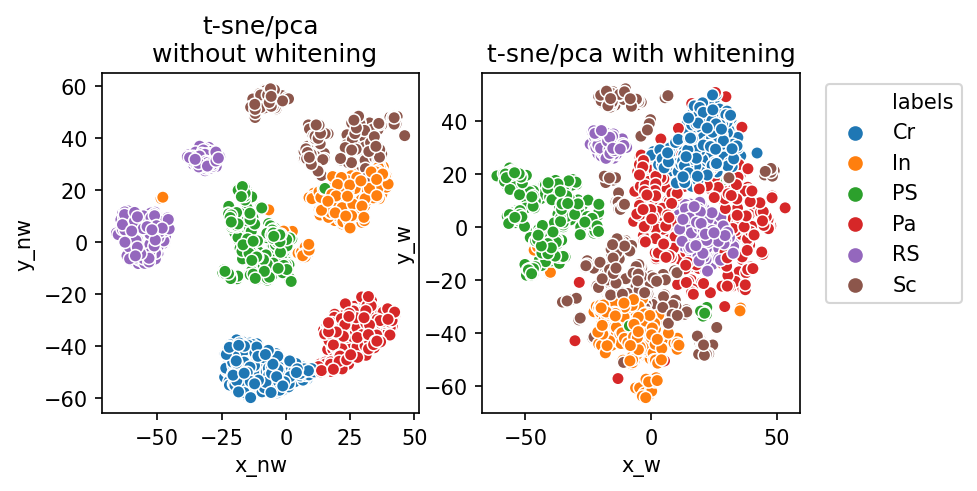

In [7]:
df = pd.DataFrame({'files': files,
                   'x_nw':x_nw_tsne[:,0],
                   'y_nw':x_nw_tsne[:,1],
                   'x_w': x_w_tsne[:,0],
                  'y_w': x_w_tsne[:,1],
                   'labels': labels,
                  },
                  index=files)

fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=150)
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=labels_ordered,  ax=ax[0])
sns.scatterplot(data=df, x='x_w', y='y_w', hue='labels', hue_order=labels_ordered, ax=ax[1])
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05,1))
ax[0].set_title('t-sne/pca\n without whitening')
ax[1].set_title('t-sne/pca with whitening')
plt.show()

The t-sne clusters still look good for unwhitened components. Whitening causes the clusters to move closer together on t-sne, the same as before. Notice how rolled-in scale (RS) now has two separate clusters, similar to scratches.

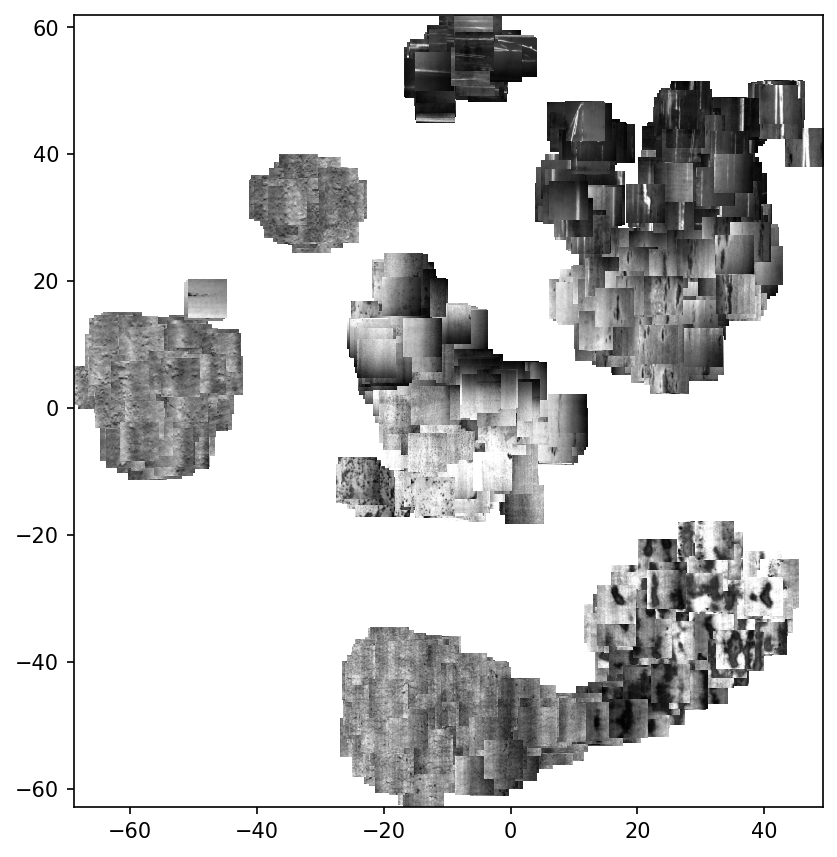

In [8]:
vis.pano_plot(x_nw_tsne[:,0], x_nw_tsne[:,1], files)

Without histogram equalization, we see the separation of some clusters by brightness. Note the two distinct clusters for RS samples that was not present before. One cluster has brighter stripes from the illumination of the images, while the other has a darker background.

# Clustering
First, we will use the same settings as before, to see the effect of removing histogram equalization on the standard analysis.

In [9]:
kmeans = KMeans(n_clusters=7, init='k-means++', 
                n_init=500,random_state=3831647997)
kmeans.fit(x)
labels_unmatched = kmeans.labels_  # labels from k-means are arbitrary and must be mapped to the format of the ground truth labels
y_pred = ct.label_matcher(labels_unmatched, y_gt,)  # this function matches the labels so we can compare directly
print('inertia: {:.2f}'.format(kmeans.inertia_))

inertia: 80608.45


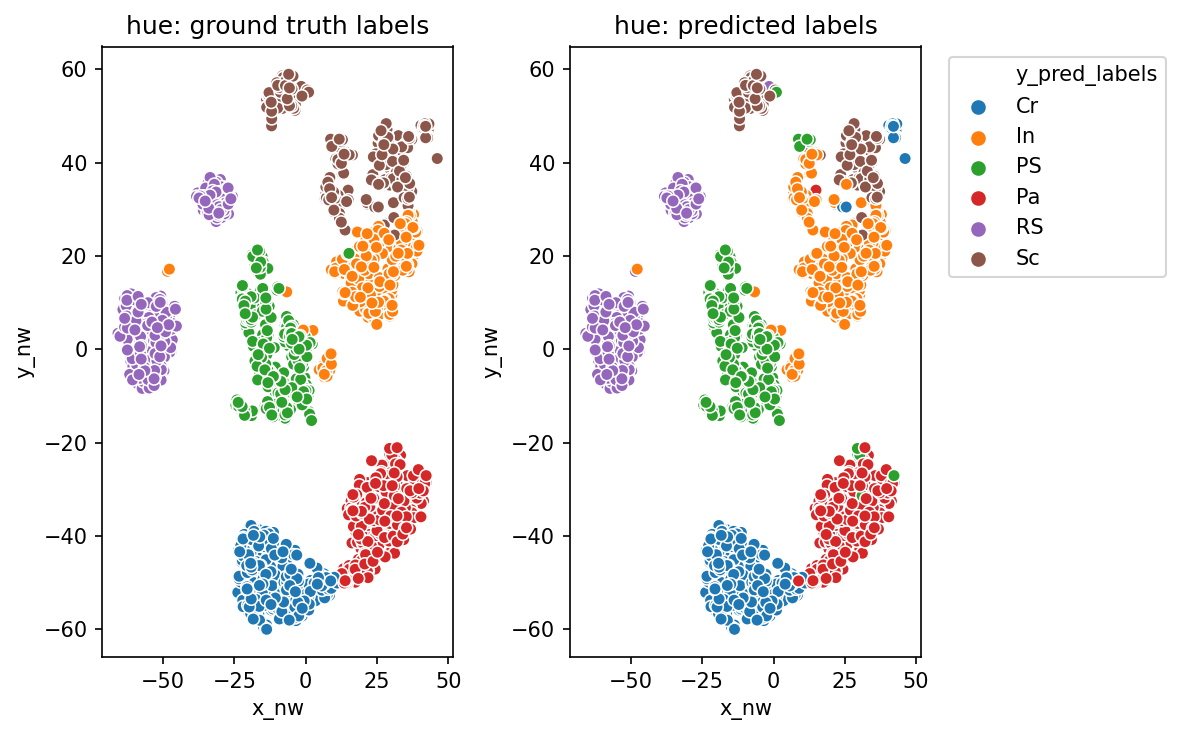

In [10]:
y_pred_str = le.inverse_transform(y_pred)
df['y_pred_labels'] = pd.Series(y_pred_str, index=files)

fig, ax = plt.subplots(1,2, figsize=(8,5), dpi=150)


sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=labels_ordered, ax=ax[0]) # ground truth labels
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='y_pred_labels', hue_order=labels_ordered, ax=ax[1]) # predicted labels

ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05,1))
ax[0].set_title('hue: ground truth labels')
ax[1].set_title('hue: predicted labels')
fig.tight_layout()
plt.show()

We can now see some significant differences between the labels. For instance- scratches (brown) being classified as inclusions (orange.)

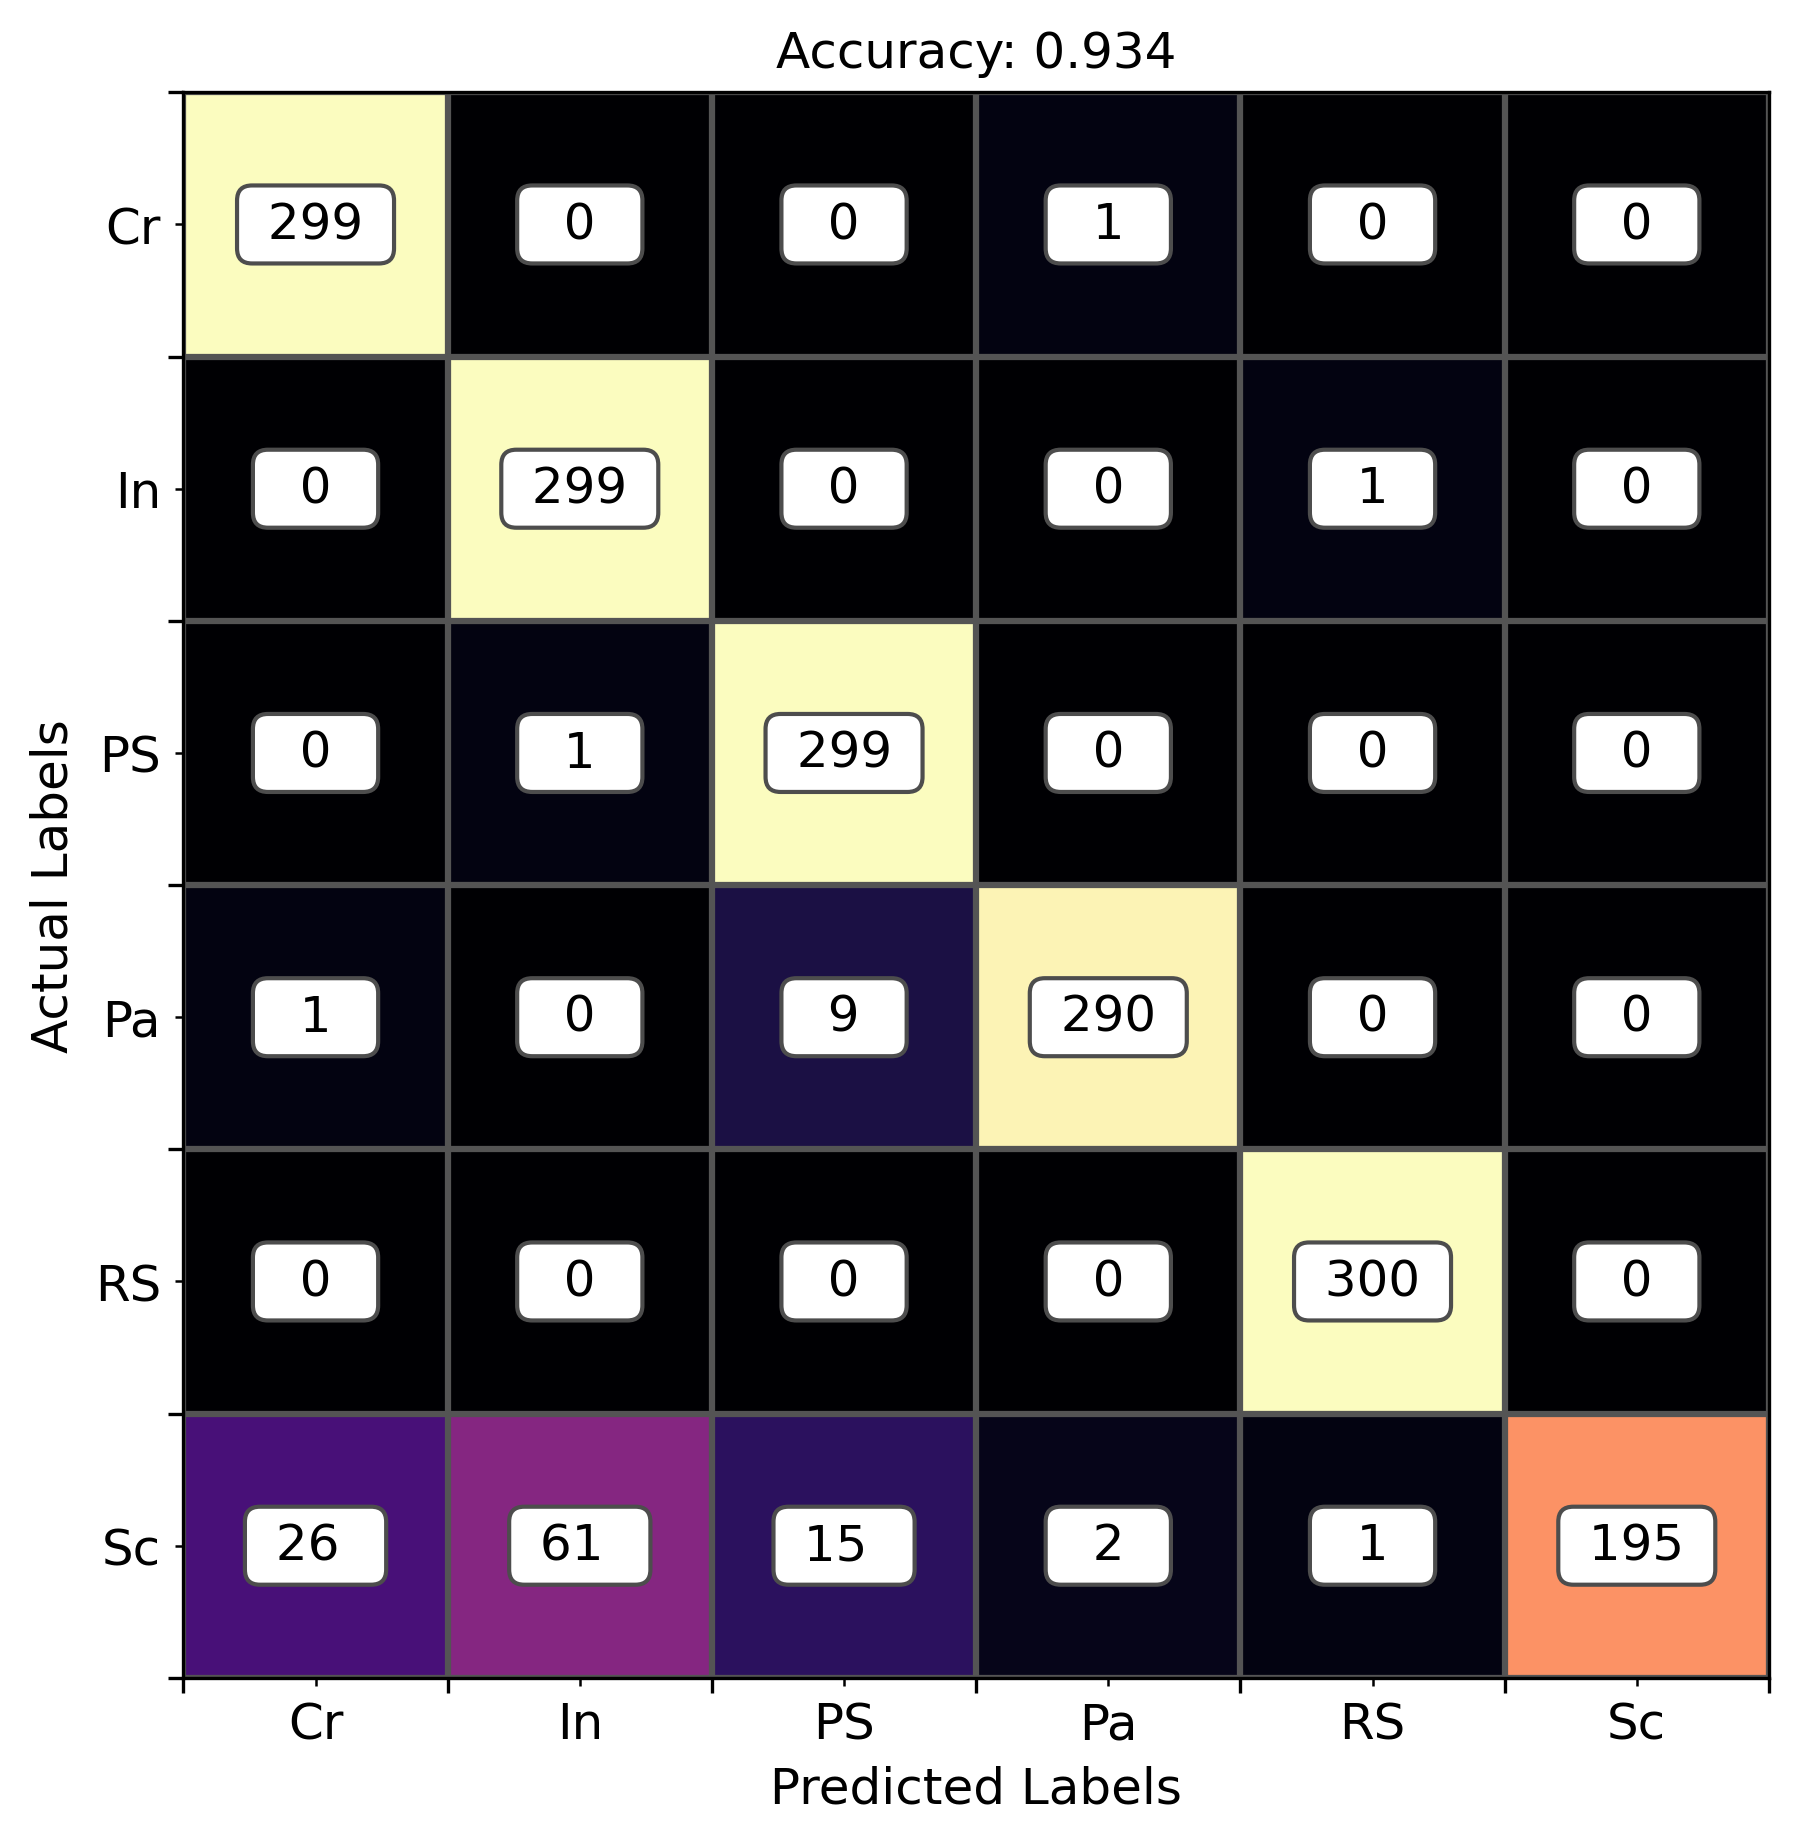

Accuracy: 0.934


In [11]:
# The confusion matrix allows us to evaluate the performance
CM = confusion_matrix(y_gt, y_pred)
vis.pretty_cm(CM, labels_ordered)
print('Accuracy: {:.3f}'.format(CM.trace()/CM.sum()))

In fact, the accuracy drops from above 99% to 93%, a significant increase in the number of misclassifications. This is driven by a large number of incorrect predictions for images of scratches.

Again, just to be sure we didn't get unlucky with the random seed, let's run it 10 times.

In [26]:
# This takes a couple minutes to run, be patient!
rs = np.random.RandomState(seed=987654321)
accuracies = np.zeros(10)
for i, seed in enumerate(rs.randint(2**32, size=10)):
    kmeans_ = KMeans(n_clusters=7, init='k-means++', n_init=500,random_state=seed)
    kmeans_.fit(x)
    labels_unmatched_ = kmeans_.labels_
    y_pred_ = ct.label_matcher(labels_unmatched_, y_gt)
    accuracies[i] = (y_pred_ == y_gt).sum()/len(y_gt)
    


print(accuracies)

[0.91111111 0.88166667 0.91833333 0.89       0.885      0.93833333
 0.89111111 0.91833333 0.88666667 0.89555556]


In [31]:
print('10 runs:\n\tavg: {:.4f}\n\tstd: {:.4},\n\tmin: {:.4f}'.format(accuracies.mean(), np.std(accuracies), accuracies.min()))

10 runs:
	avg: 0.9016
	std: 0.01782,
	min: 0.8817


# Can we do better?
From the t-sne map above, we can see that RS splits into 2 clusters. Let's adjust the number of clusters and see how this impacts the results.

In [32]:
rs = np.random.RandomState(seed=723271629)
k_values = np.arange(7,13) 
accuracies_k = np.zeros(len(k_values))

for i, k in enumerate(k_values):
    kmeans_ = KMeans(n_clusters=k, init='k-means++', n_init=500,
                     random_state=rs.randint(2**32))
    kmeans_.fit(x)
    labels_unmatched_ = kmeans_.labels_
    y_pred_ = ct.label_matcher(labels_unmatched_, y_gt)
    accuracies_k[i] = (y_pred_ == y_gt).sum()/len(y_gt)

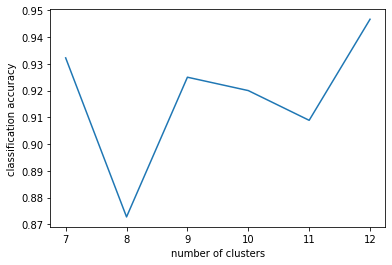

max accuracy: 0.938
num clusters: 12


In [35]:
fig, ax = plt.subplots()
ax.plot(k_values, accuracies_k)
ax.set_xlabel('number of clusters')
ax.set_ylabel('classification accuracy')
plt.show()
print('max accuracy: {:.3f}\nnum clusters: {}'.format(accuracies.max(),
                                        k_values[accuracies.argmax()]))

In [ ]:
RSgroup1 = np.logical_and(
                np.logical_and(x_nw_tsne[:,0]  < 25,
                             x_nw_tsne[:,0] > 0),
                np.logical_and(x_nw_tsne[:,1] > -20,
           x_nw_tsne[:,1] < 20))

RSgroup2 = np.logical_and(
                np.logical_and(x_nw_tsne[:,0]  < 25,
                             x_nw_tsne[:,0] > 0),
                np.logical_and(x_nw_tsne[:,1] > -20,
           x_nw_tsne[:,1] < 20))

In [ ]:
RSgroup1 = np.logical_and(x_nw_tsne[:,0] < 30, 
                          np.asarray(labels)=='RS')
RSgroup2 = np.logical_and(x_nw_tsne[:,0] > 30, 
                          np.asarray(labels)=='RS')

In [ ]:
from scipy.spatial.distance import cdist

In [ ]:
x1_Rs1 = x_nw_tsne[RSgroup1]
x1_Rs2 = x_nw_tsne[RSgroup2]

i1 = cdist(x1_Rs1, 
        np.mean(x1_Rs1, axis=0)[np.newaxis, :]).argmin()
i2 = cdist(x1_Rs2, 
        np.mean(x1_Rs2, axis=0)[np.newaxis, :]).argmin()

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], 
                hue=labels, ax=ax)
ax.plot(x1_Rs1[i1,0], x1_Rs1[i1,1], 'k*')
ax.plot(x1_Rs2[i2,0], x1_Rs2[i2,1], 'kd')


In [ ]:
labarray = np.asarray(labels)
filearray = np.asarray(files)

group1files = filearray[RSgroup1]
group2files = filearray[RSgroup2]

file1 = group1files[i1]
file2 = group2files[i2]

In [ ]:
file1, file2

In [ ]:
root = '../images/images_resize/'
f1 = root + file1
f2 = root + file2

im1 = skimage.io.imread(f1)
im2 = skimage.io.imread(f2)

No histeq -> not as good separation between clusters, RS splits into 2 clusters based on amount of defects captured in image.
---

# Figures

In [ ]:
figure = plt.figure(figsize=(6,6), dpi=300)
gs = gridspec.GridSpec(nrows=2, ncols=2)
ax1 = figure.add_subplot(gs[0,:])
ax2 = figure.add_subplot(gs[1,0])
ax3 = figure.add_subplot(gs[1,1])
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], 
                 hue=labels, ax=ax1)
l1 = ax1.legend(loc='upper center', ncol=6,
                bbox_to_anchor=(0.55,1.18), columnspacing=1)
ax1.plot(x1_Rs1[i1,0], x1_Rs1[i1,1], 'kd')
ax1.plot(x1_Rs2[i2,0], x1_Rs2[i2,1], 'ks')

ax1.set_xticks([])
ax1.set_yticks([])

h1, b1 = histogram(im1)
h2, b2 = histogram(im2)

hmax = max(h1.max(), h2.max())

ax2.imshow(im1, cmap='gray', extent=(0,1,0,1))
ax2.plot(b1/255, h1/hmax, 'r')
ax3.imshow(im2, cmap='gray', extent=(0,1,0,1))
ax3.plot(b2/255, h2/hmax, 'r')
ax3.set_yticklabels('')

bb = ax1.get_position()
ax2.set_position((0.125, *ax2.get_position().bounds[1:]))


ax1.set_title('A)', loc='left')
ax2.set_title('B)', loc='left')
ax3.set_title('C)', loc='left')
fig.tight_layout()
fig.savefig('../Publication Figures/Final Images/SA_histeq.png')